## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, 
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Two_class_classifier, Ten_class_classifier, Four_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 120
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=False)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs = server.cluster_clients_GMM(label_predicted, number_of_cluster)
    return label_predicted, cluster_idcs



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(10, 7))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Real Cluster {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [4]:
def BC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # For Fast experiment
    
    # 1. Classifier
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     model = client.learn_representation(Total_data, client.model)


    print('train classifier')
    
    
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_binary_classifier(lr = 1e-3)
        client.train_classifier(lr = 1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    print('get_global_logit')
    print("")
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logit = server.get_clients_logit_simclr(client.binary_classifier, client.classifier, client.major_class)
        client_logits.append(client_logit)
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    cluster_logits,  cluster_idcs = server.get_cluster_logits(client_logits, number_of_cluster)
    clustering_acc = server.evaluate_clustering(cluster_distribution, cluster_idcs)
    print(f'clustering_acc: {clustering_acc}')

    
    distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        distill_loaders.append(distill_loader)
        
    # 4.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
   
    
        client.distill((distill_loaders[cluster_idx]))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [5]:
# client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3])


In [6]:
def make_global_logit(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution, data_per_class_3, data_per_class_7):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier, client.major_class))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    print(f'silhouette: {silhouette}, ari: {ari}')
    
    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [7]:
def cluster_train_result_exp(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution, data_per_class_3, data_per_class_7):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        total_client_data, distill_data, alpha,
        number_of_cluster, cluster_distribution,
        data_per_class_3, data_per_class_7
    )

    
    print(f'acc after cluster distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
        
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    print(f'acc after cluster distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    print(f'acc after global distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    return client_accs, cluster_accs, global_accs

Early stopping triggered.
Epoch 5 - Train Loss: 1.3036, Train Accuracy: 61.82%, Eval Accuracy: 79.47%
Epoch 10 - Train Loss: 0.9350, Train Accuracy: 86.04%, Eval Accuracy: 90.07%
Epoch 15 - Train Loss: 0.5007, Train Accuracy: 88.60%, Eval Accuracy: 92.05%
Epoch 20 - Train Loss: 0.3429, Train Accuracy: 91.17%, Eval Accuracy: 92.72%
Epoch 25 - Train Loss: 0.2430, Train Accuracy: 93.16%, Eval Accuracy: 93.38%
Epoch 30 - Train Loss: 0.1758, Train Accuracy: 94.30%, Eval Accuracy: 94.70%
Global Logit's Accuracy: 73.46%
acc after cluster distill: 0.924, [0.94, 0.894, 0.937], 0.397
label_predicted:         0       1       2       3       4       5       6       7       8  \
0  1325.0  1118.0  1447.0     8.0   599.0     2.0   132.0   190.0    47.0   
1  1370.0  1086.0  1687.0   180.0    34.0    23.0    86.0   326.0   201.0   
2     0.0     0.0     0.0   819.0  1681.0  2500.0     0.0     0.0     0.0   
3     0.0     0.0     8.0  2024.0  1381.0  1529.0    33.0    18.0     7.0   
4   186.0    24.0

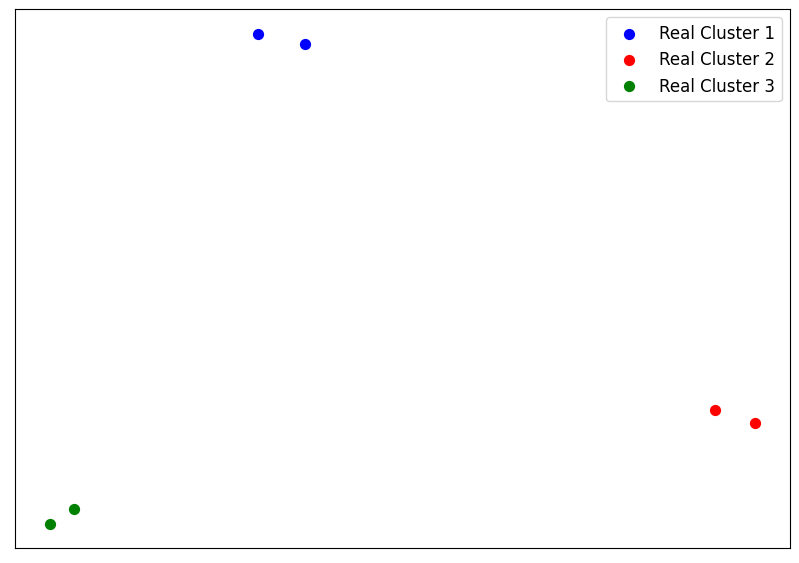

silhouette: 0.7367866039276123, ari: 1.0
client 0 distill
acc after cluster distill: 0.938, [0.944, 0.93, 0.94], 0.403
client 0 distill
acc after global distill: 0.839, [0.917, 0.689, 0.911], 0.947


([0.924, 0.938, 0.839],
 [[0.94, 0.894, 0.937], [0.944, 0.93, 0.94], [0.917, 0.689, 0.911]],
 [0.397, 0.403, 0.947])

In [12]:
# Initialize empty DataFrames to store results
df_client_accs = pd.DataFrame(columns=['before_distill', 'cluster_distill', 'global_distill'])
df_cluster_accs = pd.DataFrame(columns=['before_distill', 'cluster_distill', 'global_distill'])
df_global_accs = pd.DataFrame(columns=['before_distill', 'cluster_distill', 'global_distill'])

class_counts = [[158, 4], [150, 7], [133, 14], [117, 21], [100, 29]]
percentages = ['5%', '10%', '20%', '30%', '40%']

for class_count, percentage in zip(class_counts, percentages):
    client_1_count, client_2_count = class_count
    
    client_accs, cluster_accs, global_accs = cluster_train_result_exp(
        50000, 5000, 1, 3, [1/3, 1/3, 1/3], client_1_count, client_2_count
    )
    
    # Assuming that each of client_accs, cluster_accs, global_accs contains 3 data points
    df_client_accs.loc[percentage] = client_accs
    df_cluster_accs.loc[percentage] = cluster_accs
    df_global_accs.loc[percentage] = global_accs

In [9]:
def Global_TC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # # 0. Representational Learning
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     # print(f'data used to trian representation: {len(Total_data)}')
    #     client.learn_representation(Total_data)
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    # 2. get cluster loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier, client.major_class))
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%") 
    
    
     # 4. Distillation
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [10]:
# TC_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 117, 21)

In [11]:
clustering_by_model_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 117, 21)

NameError: name 'clustering_by_model_experiments' is not defined

In [ ]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
date_time = now.strftime("%m%d_%H%M")

columns = pd.MultiIndex.from_product([['client_accs', 'cluster_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

desired_pairs = [(50000, 5000)]
cluster_distribution = [1/3, 1/3, 1/3]
experiments = ['cluster_distill', 'sim', 'global_distill']
index = pd.MultiIndex.from_product([experiments, desired_pairs], names=['experiment', 'data_pair'])

df = pd.DataFrame(index=index, columns=columns)
runs = 2  # number of times each experiment should be run

for exp in experiments:
    for pair in desired_pairs:
        total_client_accs = [0, 0]
        total_cluster_accs = [0, 0]
        total_global_accs = [0, 0]

        for _ in range(runs):
            client_data, distill_data = pair

            if exp == 'sim':
                client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            elif exp == 'global_distill':
                client_accs, cluster_accs, global_accs = global_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            else:
                client_accs, cluster_accs, global_accs = four_class_classification_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)

            total_client_accs = [x+y for x, y in zip(total_client_accs, [client_accs[-2], client_accs[-1]])]
            total_cluster_accs = [x+y for x, y in zip(total_cluster_accs, [cluster_accs[-2], cluster_accs[-1]])]
            total_global_accs = [x+y for x, y in zip(total_global_accs, [global_accs[-2], global_accs[-1]])]

        avg_client_accs = [x/runs for x in total_client_accs]
        avg_cluster_accs = [x/runs for x in total_cluster_accs]
        avg_global_accs = [x/runs for x in total_global_accs]

        df.loc[(exp, pair), ('client_accs', 'before_distill')] = avg_client_accs[0]
        df.loc[(exp, pair), ('client_accs', 'after_distill')] = avg_client_accs[1]
        df.loc[(exp, pair), ('global_accs', 'before_distill')] = avg_global_accs[0]
        df.loc[(exp, pair), ('global_accs', 'after_distill')] = avg_global_accs[1]
        df.loc[(exp, pair), ('cluster_accs', 'before_distill')] = avg_cluster_accs[0]
        df.loc[(exp, pair), ('cluster_accs', 'after_distill')] = avg_cluster_accs[1]

directory = f'results/SimCLR'
if not os.path.exists(directory):
    os.makedirs(directory)
cluster_distribution_str = "_".join(map(str, cluster_distribution))
file_name = f'{directory}/client:{N_CLIENTS}_cluster:{NUMBER_OF_CLUSTER}_distribution:{cluster_distribution_str}_{date_time}.csv'
df = df.round(decimals=3)
df.to_csv(file_name)

In [ ]:
df = pd.read_csv('results/global_distill/CIFAR_0720_0435.csv', index_col=[0,1], header=[0,1])

# 그릴 데이터와 제목을 리스트로 저장
heatmap_data = [('client_accs', 'change_after_distill', 'Client Accuracy change after Distillation'),
                ('global_accs', 'change_after_distill', 'Global Accuracy change after Distillation')]

# Compute change in accuracy
df[('client_accs', 'change_after_distill')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change_after_distill')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# 전체 데이터의 최솟값, 최댓값 계산
vmin = min(df[data1][data2].min() for data1, data2, _ in heatmap_data)
vmax = max(df[data1][data2].max() for data1, data2, _ in heatmap_data)

for data1, data2, title in heatmap_data:
    plt.figure(figsize=(9, 5))
    sns.heatmap(df[(data1, data2)].unstack(), annot=True, cmap='coolwarm', center=0, vmin=-0.1, vmax=0.2)
    plt.title(title)
    plt.show()


## 2.Clustering 실험

In [ ]:
def do_clustering_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*10):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    # server_idcs = generate_server_idcs(test_idcs, test_labels, int(total_client_data*10))

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for epoch in range(1, LOCAL_EPOCHS+1):

        if epoch == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if epoch == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if epoch == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if epoch == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if epoch == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = pd.concat([first_accuracies, pd.DataFrame(first_acc, index=[i])])
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif epoch == LOCAL_EPOCHS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : epoch, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, LOCAL_EPOCHS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
